In [2]:
%matplotlib inline


In [3]:
import matplotlib.pyplot as plt
import matplotlib
import os
from astropy.io import ascii, fits
import glob
from scipy.ndimage import gaussian_filter1d
from astropy.time import Time
import glob
import re
from astropy.table import Table
import astropy.table as at
import astropy
import numpy as np
import extinction
import pandas as pd

In [4]:
#data_nuv = astropy.io.ascii.read('nuv_lineflux.dat', data_start=1, delimiter=' ') 
#data_nuv
data_all = astropy.io.ascii.read('all_lineflux.dat', data_start=1, delimiter=' ') 
data_all

obj,phase,NIII1746,d_NIII1746,CIII1907,d_CIII1907,NII2139,d_NII2139,CII2323,d_CII2323,MgIIFeII2650,d_MgIIFeII2650,MgII2795,d_MgII2795,NV1238,d_NV1238,OI1305,d_OI1305,CII1335,d_CII1335,SiIV1398,d_SiIV1398,NIV1483,d_NIV1483,CIV1548,d_CIV1548,HeII1640,d_HeII1640,OIII1660,d_OIII1660
str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2021csp,8,-1.623843674843143e-15,4.576225153754114e-16,2.337914393657833e-15,1.8435232598520577e-16,1.2779681573696947e-16,1.1828109859417275e-16,-1.4422116656146452e-15,1.1224027378850078e-16,-3.82360901642134e-17,9.934855696501269e-17,7.377178029150523e-16,3.798152269758618e-16,2.3821002676901454e-14,4.499858511132077e-16,2.585949008568828e-14,5.564044169277877e-16,3.5450397583771346e-14,6.900592284847332e-16,5.725660928471873e-14,8.843700337178506e-16,-3.6101459342617426e-15,9.56094761079991e-16,1.0520373296244559e-13,1.8266955285618063e-15,9.590808087391346e-15,1.2615425357260496e-15,2.005154565272468e-15,1.5376023521509854e-15
2015G,12,4.8173607498191794e-14,1.890588912285918e-15,-9.747777447721728e-15,5.881532771531051e-16,-1.5649787860103008e-14,3.597985494167334e-16,-1.4713334888882417e-15,2.67169422846726e-16,-1.1939470834954957e-15,1.6891106233198574e-16,3.335515531194934e-14,5.290136398924715e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021csp,13,4.0551804424706825e-17,4.522640638286372e-16,-7.306499600411949e-17,1.576457871404716e-16,-2.0260937532317456e-16,1.3008810595957754e-16,3.543209117639262e-16,1.236460956823161e-16,3.6535047145181633e-16,1.1546584799324885e-16,-1.2765653976027276e-15,2.4785264995473954e-16,-1.1357275938509433e-15,2.4961574840332785e-16,2.3396323040242817e-15,3.546694386622364e-16,9.445560505367856e-15,4.369923772188082e-16,2.179799791892814e-14,5.962121183900518e-16,-2.8066806520032424e-15,6.58380993315643e-16,5.338659342229867e-14,1.4140489422452507e-15,1.189458798373301e-15,7.162436589344364e-16,-2.9303197745785596e-15,9.839859891808681e-16
2020nxt,18,5.193964717435496e-15,7.363504539262741e-16,1.8647210241821974e-14,6.535637499874699e-16,-1.22214021128063e-15,2.179699649672091e-16,6.7820648538594266e-15,2.9636875383421973e-16,4.982838350847821e-16,1.7538977126129996e-16,2.805664950974009e-14,7.836548824390218e-16,1.0395671459745864e-14,2.6068046408940183e-16,-1.391822375079154e-16,1.8710213096272014e-16,2.7286644074096853e-15,2.2852768919885265e-16,9.678076845110096e-15,3.8845684619367127e-16,-3.9573621234841194e-16,3.0643600758681807e-16,2.0672292717144155e-14,8.7492185738198e-16,1.7956082533788695e-15,5.667177098424044e-16,-2.2926491949114098e-15,6.952756036506463e-16
2010jl,23,4.822974418315502e-13,2.6727218930923094e-14,2.3249629522698955e-13,1.3931272832327905e-14,1.56430479561968e-13,3.5434397056893022e-15,8.760284674790205e-14,2.3738763575317017e-15,8.926272557875981e-15,1.6984737383117604e-15,4.789130380455444e-13,4.113967199397921e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020nxt,27,8.649275141767512e-15,1.2592202941093746e-15,9.981572270122786e-15,8.995231655420144e-16,1.8529820032979103e-15,3.0970585497760277e-16,5.04963783955553e-15,3.655618583403609e-16,-3.859682768591144e-16,1.8714351782989715e-16,3.784152437184328e-14,9.242822517182602e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010jl,34,5.272587306106388e-13,2.8247005131343333e-14,2.470459151930761e-13,1.326889994357914e-14,1.742357926553672e-13,3.3233839345211493e-15,8.664085779150629e-14,2.1977353291593407e-15,1.2607317122895657e-14,1.733286337701367e-15,5.668319978150969e-13,4.1134155791138864e-15,2.503333902990041e-13,1.8827159782244414e-14,5.02903120815017e-14,1.5937982400292077e-14,-7.44063758086986e-14,1.5924944143096976e-14,6.538915064096988e-13,3.4145605042578516e-14,1.258298075432417e-12,4.6496710700890365e-14,1.0825616257127253e-12,

In [25]:
df = data_all.to_pandas()
print(df.to_latex(float_format="%.2e",index=False))

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
     obj &  phase &  NIII1746 &  d\_NIII1746 &  CIII1907 &  d\_CIII1907 &   NII2139 &  d\_NII2139 &   CII2323 &  d\_CII2323 &  MgIIFeII2650 &  d\_MgIIFeII2650 &  MgII2795 &  d\_MgII2795 &    NV1238 &  d\_NV1238 &    OI1305 &  d\_OI1305 &   CII1335 &  d\_CII1335 &  SiIV1398 &  d\_SiIV1398 &   NIV1483 &  d\_NIV1483 &  CIV1548 &  d\_CIV1548 &  HeII1640 &  d\_HeII1640 &  OIII1660 &  d\_OIII1660 \\
\midrule
 2021csp &      8 & -1.62e-15 &    4.58e-16 &  2.34e-15 &    1.84e-16 &  1.28e-16 &   1.18e-16 & -1.44e-15 &   1.12e-16 &     -3.82e-17 &        9.93e-17 &  7.38e-16 &    3.80e-16 &  2.38e-14 &  4.50e-16 &  2.59e-14 &  5.56e-16 &  3.55e-14 &   6.90e-16 &  5.73e-14 &    8.84e-16 & -3.61e-15 &   9.56e-16 & 1.05e-13 &   1.83e-15 &  9.59e-15 &    1.26e-15 &  2.01e-15 &    1.54e-15 \\
   2015G &     12 &  4.82e-14 &    1.89e-15 & -9.75e-15 &    5.88e-16 & -1.56e-14 &   3.60e-16 & -1.47e-15 &   2.67e-16 &     -1.19e-15 &        1.69e-16 

In [83]:
def conv2siunitx(val, err, err_points=2):
    val = f'{val:.20e}'.split('e')
    err = f'{err:.20e}'.split('e') 
    first_uncertain = int(val[1]) - int(err[1]) + err_points

    #my_val = f'{np.round(float(val[0]), first_uncertain-1):.11f}'
    #my_err = f'{np.round(float(err[0]), err_points-1):.11f}'.replace('.','')
    my_val = f'{np.round(float(val[0]), first_uncertain-1)}'
    my_err = f'{np.round(float(err[0]), err_points-1)}'.replace('.','')
    # Avoid 1. and write 1 instead
    if first_uncertain > 1:
        first_uncertain = first_uncertain + 1

    return(f'{my_val[:first_uncertain]}({my_err[:err_points]})e{val[1]}')

In [64]:
#conv2siunitx(df['NIII1746'],df['d_NIII1746'],err_points=1)
#conv2siunitx(5,1,err_points=1)
#df[['NIII1746','d_NIII1746']].apply(conv2siunitx,axis=1)
#df.apply(lambda x: conv2siunitx(x['NIII1746'], x['d_NIII1746']), axis=1)
#df.apply(lambda x: conv2siunitx(x.iloc[:, 2::2], x.iloc[:, 3::2]), axis=1)
#df.apply(lambda x: conv2siunitx(x.column[2], x.colum[3]), axis=1)
#df[df.iloc[:, 2::2], df.iloc[:, 3::2]].apply(lambda x: conv2siunitx(*x), axis=1)
#df[['NIII1746','d_NIII1746']].apply(lambda x: conv2siunitx(*x), axis=1)
df.iloc[:, 2:4].apply(lambda x: conv2siunitx(*x), axis=1)

0     -1.(5)e-15
1     4.8(2)e-14
2        (5)e-17
3     5.2(7)e-15
4     4.8(3)e-13
5       9(1)e-15
6     5.3(3)e-13
7       4(1)e-15
8     6.0(5)e-13
9       2(9)e-16
10      3(1)e-15
11       (5)e-17
12      0(0)e+00
13      3(9)e-16
14    2.1(2)e-14
15      1(4)e-15
16      2(3)e-15
17    1.3(3)e-14
18      9(4)e-15
dtype: object

In [107]:
#df.columns[2:14:2]
[df.columns[0:2],df.columns[14:14+18:2]]

[Index(['obj'], dtype='object'),
 Index(['NV1238', 'OI1305', 'CII1335', 'SiIV1398', 'NIV1483', 'CIV1548',
        'HeII1640', 'OIII1660'],
       dtype='object')]

In [161]:
newdf=df.iloc[:, 0:2]
nel=len(df.columns)
nel=int(nel/2.-1)
nel=6
for x in range(nel):
    idx=2+2*x
    add=pd.DataFrame(df.iloc[:, idx:idx+2].apply(lambda x: conv2siunitx(*x), axis=1))
    add.columns=[df.columns[idx]]
    newdf=pd.concat([newdf,add],axis=1)

newdf_fuv=newdf
newdf_fuv

,obj,phase,NIII1746,CIII1907,NII2139,CII2323,MgIIFeII2650,MgII2795
0,2021csp,8,-1.6(46)e-15,2.34(18)e-15,1.3(12)e-16,-1.4(11)e-15,-3.(99)e-17,7.4(38)e-16
1,2015G,12,4.82(19)e-14,-9.7(59)e-15,-1.56(36)e-14,-1.4(27)e-15,-1.1(17)e-15,3.336(53)e-14
2,2021csp,13,4(45)e-17,-(16)e-17,-2.(13)e-16,3.5(12)e-16,3.7(12)e-16,-1.2(25)e-15
3,2020nxt,18,5.19(74)e-15,1.865(65)e-14,-1.2(22)e-15,6.78(30)e-15,5.0(18)e-16,2.806(78)e-14
4,2010jl,23,4.82(27)e-13,2.32(14)e-13,1.564(35)e-13,8.76(24)e-14,8.9(17)e-15,4.789(41)e-13
5,2020nxt,27,8.6(13)e-15,9.98(90)e-15,1.85(31)e-15,5.05(37)e-15,-3.(19)e-16,3.784(92)e-14
6,2010jl,34,5.27(28)e-13,2.47(13)e-13,1.742(33)e-13,8.66(22)e-14,1.26(17)e-14,5.668(41)e-13
7,1998S,71,3.9(11)e-15,4.78(70)e-15,1.92(45)e-15,8.02(39)e-15,9.9(31)e-16,5.68(18)e-13
8,2010jl,95,6.01(53)e-13,2.75(14)e-13,2.217(38)e-13,1.21(25)e-13,1.36(19)e-14,1.6291(55)e-12
9,2020aekp,203,1.5(87)e-16,1.47(52)e-15,(30)e-18,5.5(23)e-16,-1.(13)e-16,5.9(78)e-16


In [163]:
newdf=df.iloc[:, 0:2]
nel=len(df.columns)
nel=int(nel/2.-1)
nel=8
for x in range(nel):
    idx=2+2*x+6
    add=pd.DataFrame(df.iloc[:, idx:idx+2].apply(lambda x: conv2siunitx(*x), axis=1))
    add.columns=[df.columns[idx]]
    newdf=pd.concat([newdf,add],axis=1)
    
newdf_nuv=newdf
newdf_nuv

,obj,phase,CII2323,MgIIFeII2650,MgII2795,NV1238,OI1305,CII1335,SiIV1398,NIV1483
0,2021csp,8,-1.4(11)e-15,-3.(99)e-17,7.4(38)e-16,2.382(45)e-14,2.586(56)e-14,3.545(69)e-14,5.726(88)e-14,-3.6(96)e-15
1,2015G,12,-1.4(27)e-15,-1.1(17)e-15,3.336(53)e-14,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00
2,2021csp,13,3.5(12)e-16,3.7(12)e-16,-1.2(25)e-15,-1.1(25)e-15,2.34(35)e-15,9.45(44)e-15,2.18(60)e-14,-2.8(66)e-15
3,2020nxt,18,6.78(30)e-15,5.0(18)e-16,2.806(78)e-14,1.04(26)e-14,-1.(19)e-16,2.73(23)e-15,9.68(39)e-15,-4.(31)e-16
4,2010jl,23,8.76(24)e-14,8.9(17)e-15,4.789(41)e-13,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00
5,2020nxt,27,5.05(37)e-15,-3.(19)e-16,3.784(92)e-14,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00,0.0(00)e+00
6,2010jl,34,8.66(22)e-14,1.26(17)e-14,5.668(41)e-13,2.5(19)e-13,5.0(16)e-14,-7.(16)e-14,6.54(34)e-13,1.258(46)e-12
7,1998S,71,8.02(39)e-15,9.9(31)e-16,5.68(18)e-13,7.04(39)e-15,2.623(55)e-14,1.75(35)e-15,1.1(57)e-14,1.263(55)e-14
8,2010jl,95,1.21(25)e-13,1.36(19)e-14,1.6291(55)e-12,2.246(10)e-13,4.54(88)e-14,-4.4(86)e-14,3.65(17)e-13,8.76(21)e-13
9,2020aekp,203,5.5(23)e-16,-1.(13)e-16,5.9(78)e-16,-3.0(70)e-16,1.05(66)e-16,-2.3(47)e-16,5.8(12)e-16,3.4(11)e-16


In [164]:
print(newdf_fuv.to_latex(float_format="%.2e",index=False))

\begin{tabular}{lrllllll}
\toprule
     obj &  phase &     NIII1746 &      CIII1907 &       NII2139 &      CII2323 & MgIIFeII2650 &       MgII2795 \\
\midrule
 2021csp &      8 & -1.6(46)e-15 &  2.34(18)e-15 &   1.3(12)e-16 & -1.4(11)e-15 &  -3.(99)e-17 &    7.4(38)e-16 \\
   2015G &     12 & 4.82(19)e-14 &  -9.7(59)e-15 & -1.56(36)e-14 & -1.4(27)e-15 & -1.1(17)e-15 &  3.336(53)e-14 \\
 2021csp &     13 &    4(45)e-17 &     -(16)e-17 &   -2.(13)e-16 &  3.5(12)e-16 &  3.7(12)e-16 &   -1.2(25)e-15 \\
 2020nxt &     18 & 5.19(74)e-15 & 1.865(65)e-14 &  -1.2(22)e-15 & 6.78(30)e-15 &  5.0(18)e-16 &  2.806(78)e-14 \\
  2010jl &     23 & 4.82(27)e-13 &  2.32(14)e-13 & 1.564(35)e-13 & 8.76(24)e-14 &  8.9(17)e-15 &  4.789(41)e-13 \\
 2020nxt &     27 &  8.6(13)e-15 &  9.98(90)e-15 &  1.85(31)e-15 & 5.05(37)e-15 &  -3.(19)e-16 &  3.784(92)e-14 \\
  2010jl &     34 & 5.27(28)e-13 &  2.47(13)e-13 & 1.742(33)e-13 & 8.66(22)e-14 & 1.26(17)e-14 &  5.668(41)e-13 \\
   1998S &     71 &  3.9(11)e-15 &  

In [165]:
print(newdf_nuv.to_latex(float_format="%.2e",index=False))

\begin{tabular}{lrllllllll}
\toprule
     obj &  phase &      CII2323 & MgIIFeII2650 &       MgII2795 &        NV1238 &        OI1305 &       CII1335 &      SiIV1398 &       NIV1483 \\
\midrule
 2021csp &      8 & -1.4(11)e-15 &  -3.(99)e-17 &    7.4(38)e-16 & 2.382(45)e-14 & 2.586(56)e-14 & 3.545(69)e-14 & 5.726(88)e-14 &  -3.6(96)e-15 \\
   2015G &     12 & -1.4(27)e-15 & -1.1(17)e-15 &  3.336(53)e-14 &   0.0(00)e+00 &   0.0(00)e+00 &   0.0(00)e+00 &   0.0(00)e+00 &   0.0(00)e+00 \\
 2021csp &     13 &  3.5(12)e-16 &  3.7(12)e-16 &   -1.2(25)e-15 &  -1.1(25)e-15 &  2.34(35)e-15 &  9.45(44)e-15 &  2.18(60)e-14 &  -2.8(66)e-15 \\
 2020nxt &     18 & 6.78(30)e-15 &  5.0(18)e-16 &  2.806(78)e-14 &  1.04(26)e-14 &   -1.(19)e-16 &  2.73(23)e-15 &  9.68(39)e-15 &   -4.(31)e-16 \\
  2010jl &     23 & 8.76(24)e-14 &  8.9(17)e-15 &  4.789(41)e-13 &   0.0(00)e+00 &   0.0(00)e+00 &   0.0(00)e+00 &   0.0(00)e+00 &   0.0(00)e+00 \\
 2020nxt &     27 & 5.05(37)e-15 &  -3.(19)e-16 &  3.784(92)e-14 &

In [ ]:
obj	phase	NIII1746	d_NIII1746	CIII1907	d_CIII1907	NII2139	d_NII2139	CII2323	d_CII2323	MgIIFeII2650	d_MgIIFeII2650	MgII2795	d_MgII2795	NV1238	d_NV1238	OI1305	d_OI1305	CII1335	d_CII1335	SiIV1398	d_SiIV1398	NIV1483	d_NIV1483	CIV1548	d_CIV1548	HeII1640	d_HeII1640	OIII1660	d_OIII1660

In [4]:
obj= data_all["obj"]
phase = data_all["phase"]

NV1238 = data_all["NV1238"]
d_NV1238 = data_all["d_NV1238"]
OI1305 = data_all["OI1305"]
d_OI1305 = data_all["d_OI1305"]
CII1335 = data_all["CII1335"]
d_CII1335 = data_all["d_CII1335"]
SiIV1398 = data_all["SiIV1398"]
d_SiIV1398  = data_all["d_SiIV1398"]
NIV1483  = data_all["NIV1483"]
d_NIV1483  = data_all["d_NIV1483"]
CIV1548  = data_all["CIV1548"]
d_CIV1548 = data_all["d_CIV1548"]
HeII1640 = data_all["HeII1640"]
d_HeII1640 = data_all["d_HeII1640"]
OIII1660 = data_all["d_OIII1660"]
d_OIII1660 = data_all["d_OIII1660"]

NIII1746 = data_all["NIII1746"]
d_NIII1746 = data_all["d_NIII1746"]
CIII1907 = data_all["CIII1907"]
d_CIII1907 = data_all["d_CIII1907"]
NII2139 = data_all["NII2139"]
d_NII2139 = data_all["d_NII2139"]
CII2323 = data_all["CII2323"]
d_CII2323  = data_all["d_CII2323"]
MgIIFeII2650  = data_all["MgIIFeII2650"]
d_MgIIFeII2650  = data_all["d_MgIIFeII2650"]
MgII2795  = data_all["MgII2795"]
d_MgII2795 = data_all["d_MgII2795"]
obj

2021csp
2015G
2021csp
2020nxt
2010jl
2020nxt
2010jl
1998S
2010jl
2020aekp
1998S


In [5]:
#sntype = ["IIn","Icn","Icn","Ibn","Ibn","Ibn","IIn","IIn","IIn","IIn","IIn","IIn","IIn","IIn","IIn","Ia-CSM","Ia-CSM","IIn"]
sntype = ["Icn","Ibn","Icn","Ibn","IIn","Ibn","IIn","IIn","IIn","Ia-CSM","IIn","Ia-CSM",
          "IIn","IIn","IIn","IIn","IIn","IIn","IIn"]

# NUV

# NIII1746/CIII1907

In [6]:
#NIII1746/CIII1907
yax = np.array(NIII1746)/np.array(CIII1907)
xax = np.array(NIII1746)
xerr = np.array(d_NIII1746)
yerr = np.array(d_CIII1907)
yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_NIII1746)/np.array(NIII1746))]
yerr_all = yerr_all.flatten()




/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2774811291.py:2: RuntimeWarning: invalid value encountered in true_divide
  yax = np.array(NIII1746)/np.array(CIII1907)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2774811291.py:6: RuntimeWarning: invalid value encountered in true_divide
  yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_NIII1746)/np.array(NIII1746))]


/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/3624898902.py:59: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,5000])


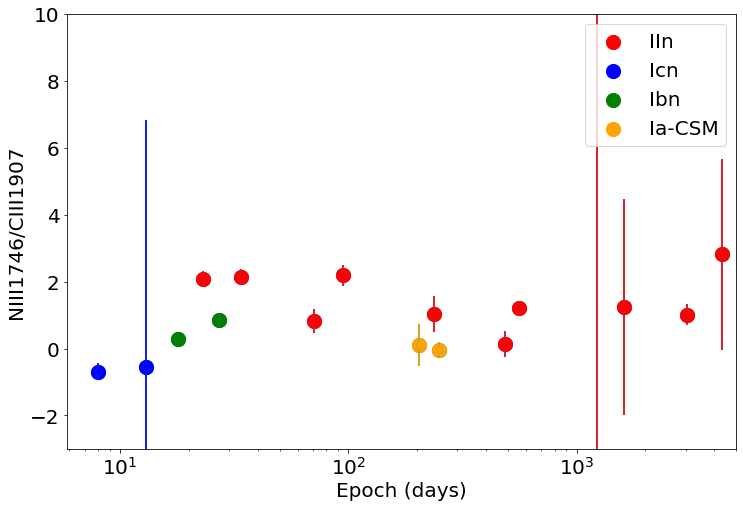

In [7]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(12,8))

#plt.errorbar(xax, yax, yerr=yerr_all, fmt="o")
#plt.scatter(xax, yax, marker='o',s=200)
plt.errorbar(phase, yax, yerr=yerr_all, fmt="o")
plt.scatter(phase, yax, marker='o',s=200)

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

#ax.set_xlabel("NIII1746")
ax.set_xlabel("Epoch (days)")
ax.set_ylabel("NIII1746/CIII1907")
plt.xscale('log')

#ax.set_ylim(-10,10)
#ax.set_xlim(-0.1e-13,1e-13)

#xaxlabel=xax+0.02e-13
xaxlabel=phase
yaxlabel=yax

for i in range(len(obj)):
    label = sntype[i]+' '+str(phase[i])
    print,label
    #if xaxlabel[i] < 1e-13:
    #if xaxlabel[i] < 500:
    #    plt.text(xaxlabel[i],yaxlabel[i],label,fontsize=12)

plt.legend()
plt.ylim([-3,10])
#plt.xlim([-0.1e-13,0.6e-13])
plt.xlim([0,5000])
plt.savefig('NIII1746dCIII1907.jpg', dpi=100)
plt.show()

In [38]:
#NIII1746/CIII1907
yax = np.array(NIII1746)/np.array(CIII1907)
xax = np.array(NIII1746)
xerr = np.array(d_NIII1746)
yerr = np.array(d_CIII1907)
yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_NIII1746)/np.array(NIII1746))]
yerr_all = yerr_all.flatten()




/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2774811291.py:2: RuntimeWarning: invalid value encountered in true_divide
  yax = np.array(NIII1746)/np.array(CIII1907)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2774811291.py:6: RuntimeWarning: invalid value encountered in true_divide
  yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_NIII1746)/np.array(NIII1746))]


/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/1442423039.py:33: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([-0.1e-13,0.2e-13])


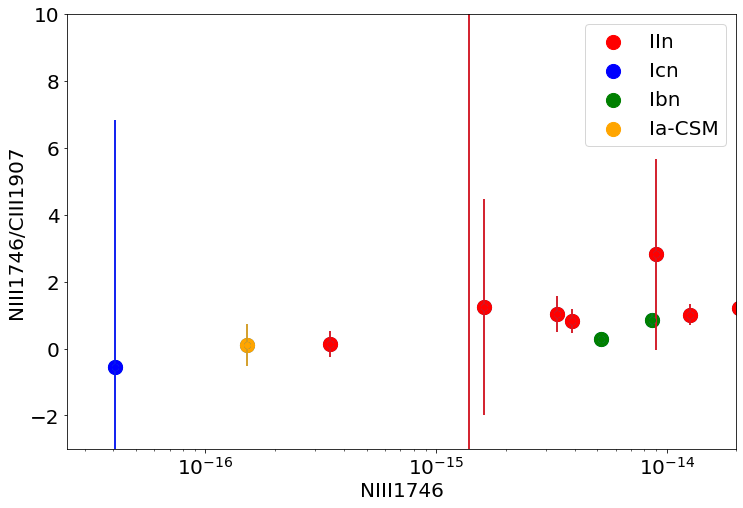

In [39]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(12,8))

plt.errorbar(xax, yax, yerr=yerr_all, fmt="o")
plt.scatter(xax, yax, marker='o',s=200)

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

ax.set_xlabel("NIII1746")
ax.set_ylabel("NIII1746/CIII1907")
plt.xscale('log')

plt.legend()
plt.ylim([-3,10])
plt.xlim([-0.1e-13,0.2e-13])
plt.savefig('NIII1746dCIII1907_colormag.jpg', dpi=100)
plt.show()

# CIII1907 vs CII2323

In [8]:
#CIII1907 vs CII2323
yax = np.array(CIII1907)/np.array(CII2323)
#yerr_all = np.array(d_CIII1907)
yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_CII2323)/np.array(CII2323))]
yerr_all = yerr_all.flatten()

xax = np.array(CII2323)
xerr_all = np.array(d_CII2323)


/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/3372253207.py:2: RuntimeWarning: invalid value encountered in true_divide
  yax = np.array(CIII1907)/np.array(CII2323)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/3372253207.py:4: RuntimeWarning: invalid value encountered in true_divide
  yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_CII2323)/np.array(CII2323))]


/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/1577096680.py:57: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,5000])


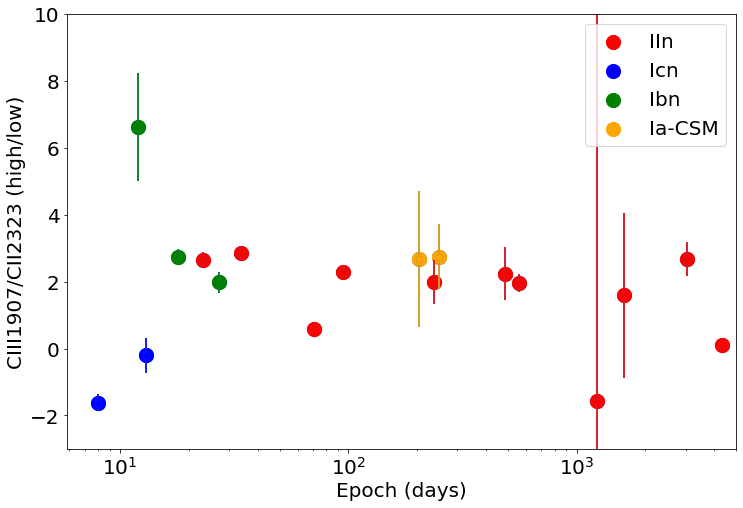

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

#plt.errorbar(xax, yax, yerr=yerr_all, fmt="o")
#plt.scatter(xax, yax, marker='o',s=200)
plt.errorbar(phase, yax, yerr=yerr_all, fmt="o")
plt.scatter(phase, yax, marker='o',s=200)

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

#ax.set_xlabel("CII2323 (low ionization)")
ax.set_xlabel("Epoch (days)")
ax.set_ylabel("CIII1907/CII2323 (high/low)")
plt.xscale('log')

xaxlabel=xax#+0.02e-13
xaxlabel=phase
yaxlabel=yax


for i in range(len(obj)):
    label = sntype[i]+' '+str(phase[i])
    print,label
    #if xaxlabel[i] < 0.2e-13:
    #if xaxlabel[i] < 500:
    #    plt.text(xaxlabel[i],yaxlabel[i],label,fontsize=12)

plt.legend()
#plt.ylim([-0.1e-13,0.6e-13])
plt.ylim([-3,10])
#plt.xlim([-0.1e-13,0.2e-13])
plt.xlim([0,5000])
plt.rcParams.update({'font.size': 20})
plt.savefig('CIII1907vCII2323.jpg', dpi=100)
plt.show()



In [43]:
#CIII1907 vs CII2323
yax = np.array(CIII1907)/np.array(CII2323)
#yerr_all = np.array(d_CIII1907)
yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_CII2323)/np.array(CII2323))]
yerr_all = yerr_all.flatten()

xax = np.array(CII2323)
xerr_all = np.array(d_CII2323)

/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/3747163637.py:2: RuntimeWarning: invalid value encountered in true_divide
  yax = np.array(CIII1907)/np.array(CII2323)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/3747163637.py:4: RuntimeWarning: invalid value encountered in true_divide
  yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_CII2323)/np.array(CII2323))]


/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/1912440704.py:33: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([-0.1e-13,0.2e-13])


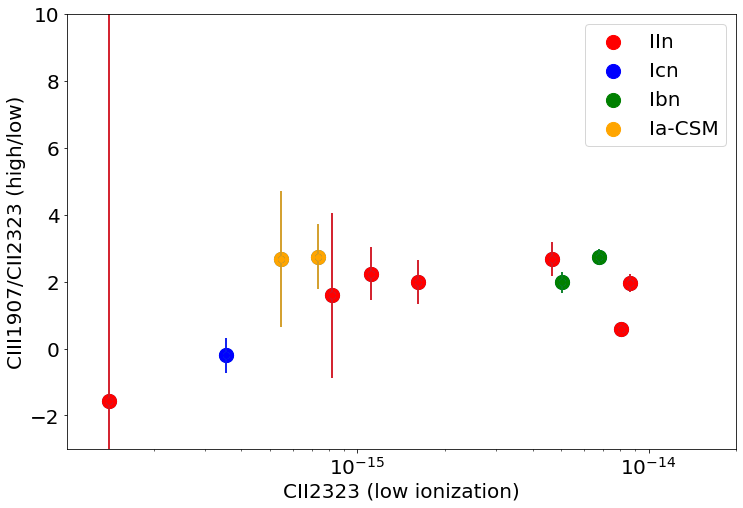

In [44]:
fig, ax = plt.subplots(figsize=(12,8))

plt.errorbar(xax, yax, yerr=yerr_all, fmt="o")
plt.scatter(xax, yax, marker='o',s=200)

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

ax.set_xlabel("CII2323 (low ionization)")
ax.set_ylabel("CIII1907/CII2323 (high/low)")
plt.xscale('log')

plt.legend()
#plt.ylim([-0.1e-13,0.6e-13])
plt.ylim([-3,10])
plt.xlim([-0.1e-13,0.2e-13])
plt.rcParams.update({'font.size': 20})
plt.savefig('CIII1907vCII2323.jpg', dpi=100)
plt.show()




# Mg Line

In [10]:
#MgII2795
yax = np.array(MgII2795)
yerr_all = np.array(d_MgII2795)
#yerr_all = abs(yax)*[abs(np.array(d_CIII1907)/np.array(CIII1907)) + abs(np.array(d_CII2323)/np.array(CII2323))]
#yerr_all = yerr_all.flatten()

/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/1510524348.py:57: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,5000])


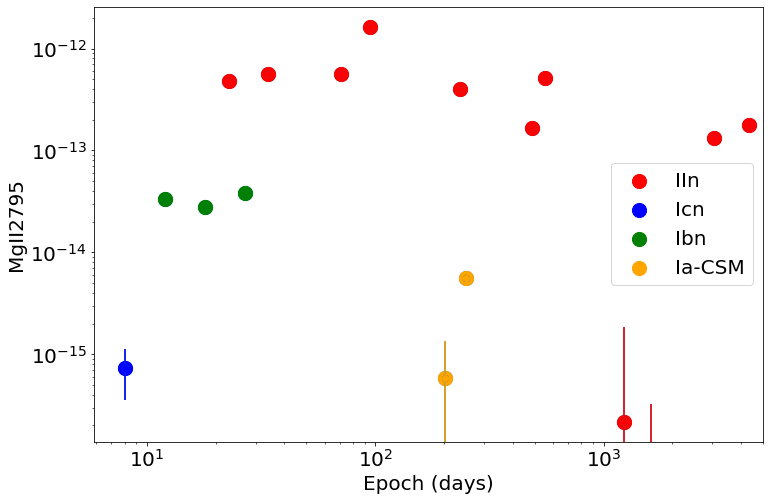

In [11]:
fig, ax = plt.subplots(figsize=(12,8))

#plt.errorbar(xax, yax, yerr=yerr_all, fmt="o")
#plt.scatter(xax, yax, marker='o',s=200)
plt.errorbar(phase, yax, yerr=yerr_all, fmt="o")
plt.scatter(phase, yax, marker='o',s=200)

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

#ax.set_xlabel("CII2323 (low ionization)")
ax.set_xlabel("Epoch (days)")
ax.set_ylabel("MgII2795")
plt.xscale('log')
plt.yscale('log')

xaxlabel=xax#+0.02e-13
xaxlabel=phase
yaxlabel=yax


for i in range(len(obj)):
    label = sntype[i]+' '+str(phase[i])
    print,label
    #if xaxlabel[i] < 0.2e-13:
    #if xaxlabel[i] < 500:
    #    plt.text(xaxlabel[i],yaxlabel[i],label,fontsize=12)

plt.legend()
#plt.ylim([-10,10])
#plt.ylim([-0.1e-13,0.2e-11])
plt.xlim([0,5000])
plt.rcParams.update({'font.size': 20})
plt.savefig('MgII2795.jpg', dpi=100)
plt.show()




## FUV

In [12]:
#NIV1483/CIV1548 
yax = np.array(NIV1483)/np.array(CIV1548)
xax = np.array(NIV1483)
xerr = np.array(d_NIV1483)
yerr = np.array(d_CIV1548)
yerr_all = abs(yax)*[abs(np.array(d_CIV1548)/np.array(CIV1548)) + abs(np.array(d_NIV1483)/np.array(NIV1483))]
yerr_all = yerr_all.flatten()

/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/4065062419.py:2: RuntimeWarning: invalid value encountered in true_divide
  yax = np.array(NIV1483)/np.array(CIV1548)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/4065062419.py:6: RuntimeWarning: invalid value encountered in true_divide
  yerr_all = abs(yax)*[abs(np.array(d_CIV1548)/np.array(CIV1548)) + abs(np.array(d_NIV1483)/np.array(NIV1483))]


/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2802197582.py:54: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,5000])


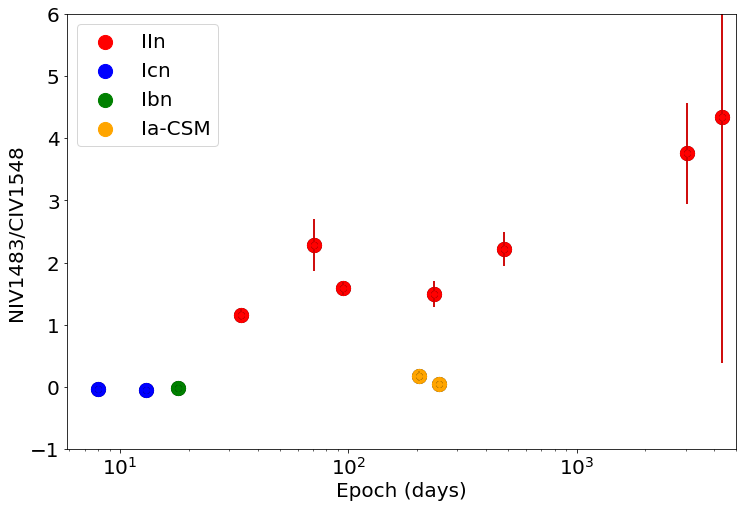

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

#plt.errorbar(xax, yax, yerr=yerr_all, fmt="o", color="black")
#plt.scatter(xax, yax, marker='o',s=200, color="black")
plt.errorbar(phase, yax, yerr=yerr_all, fmt="o", color="black")
plt.scatter(phase, yax, marker='o',s=200, color="black")

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

#ax.set_xlabel("NIV1483",size=20)
ax.set_xlabel("Epoch (days)")
ax.set_ylabel("NIV1483/CIV1548",size=20)
plt.xscale('log')

#xaxlabel=xax+0.1e-14
xaxlabel=phase
yaxlabel=yax


for i in range(len(obj)):
    label = sntype[i]+' '+str(phase[i])
    print,label
    #if xaxlabel[i] < 500:
    #    plt.text(xaxlabel[i],yax[i],label,fontsize=12)

plt.legend()
plt.ylim([-1,6])
plt.xlim([0,5000])
plt.rcParams.update({'font.size': 20})
plt.savefig('NIV1483dCIV1548.jpg', dpi=100)
plt.show()

In [14]:
#NIV1483/OIII1660 
yax = np.array(NIV1483)/np.array(OIII1660)
xax = np.array(NIV1483)
xerr = np.array(d_NIV1483)
#yerr = np.array(d_OIII1660)
yerr_all = abs(yax)*[abs(np.array(d_OIII1660)/np.array(OIII1660)) + abs(np.array(d_NIV1483)/np.array(NIV1483))]
yerr_all = yerr_all.flatten()

/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/829839891.py:2: RuntimeWarning: divide by zero encountered in true_divide
  yax = np.array(NIV1483)/np.array(OIII1660)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/829839891.py:2: RuntimeWarning: invalid value encountered in true_divide
  yax = np.array(NIV1483)/np.array(OIII1660)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/829839891.py:6: RuntimeWarning: invalid value encountered in true_divide
  yerr_all = abs(yax)*[abs(np.array(d_OIII1660)/np.array(OIII1660)) + abs(np.array(d_NIV1483)/np.array(NIV1483))]


/Users/ofox/miniconda3/envs/ers1288/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/3360111337.py:54: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,5000])


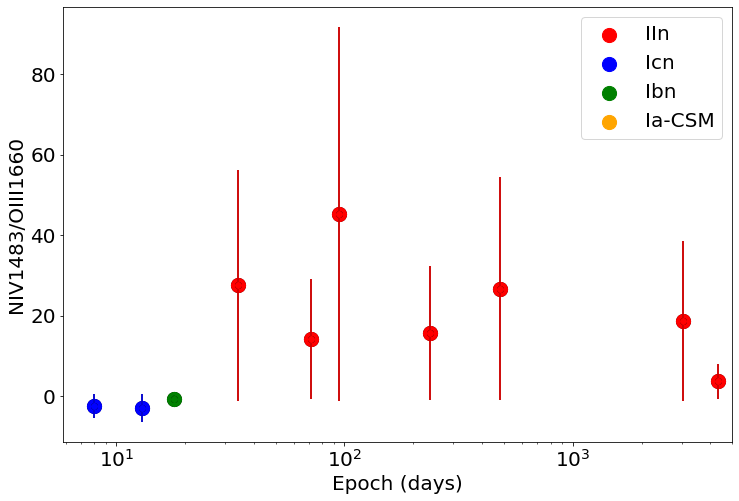

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

#plt.errorbar(xax, yax, yerr=yerr_all, fmt="o",color="black")
#plt.scatter(xax, yax, marker='o',s=200,color="black")
plt.errorbar(phase, yax, yerr=yerr_all, fmt="o",color="black")
plt.scatter(phase, yax, marker='o',s=200,color="black")

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

#ax.set_xlabel("NIV1483")
ax.set_xlabel("Epoch (days)")
ax.set_ylabel("NIV1483/OIII1660")
plt.xscale('log')

#xaxlabel=xax+0.05e-14
xaxlabel=phase
yaxlabel=yax


for i in range(len(obj)):
    label = sntype[i]+' '+str(phase[i])
    print,label
    #if xaxlabel[i] < 500:
    #    plt.text(xaxlabel[i],yax[i],label,fontsize=12)

plt.legend()
#plt.ylim([-4,4])
plt.xlim([0,5000])
plt.rcParams.update({'font.size': 20})
plt.savefig('NIV1483dOIII1660.jpg')
plt.show()

## All Lines

In [16]:
#NIII1746/OIII1660
yax = np.array(NIII1746)/np.array(OIII1660)
yerr_all = abs(yax)*[abs(np.array(d_NIII1746)/np.array(NIII1746)) + abs(np.array(d_OIII1660)/np.array(OIII1660))]
yerr_all = yerr_all.flatten()
yax

/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2095872549.py:2: RuntimeWarning: divide by zero encountered in true_divide
  yax = np.array(NIII1746)/np.array(OIII1660)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2095872549.py:3: RuntimeWarning: invalid value encountered in true_divide
  yerr_all = abs(yax)*[abs(np.array(d_NIII1746)/np.array(NIII1746)) + abs(np.array(d_OIII1660)/np.array(OIII1660))]


array([-1.05608818,         inf,  0.04121177,  7.47036814,         inf,
               inf, 11.57852393,  4.3809034 , 31.10296973,         inf,
        4.4503068 ,        -inf,  0.        ,         inf,         inf,
               inf,         inf, 17.17386123, 12.17936867])

/Users/ofox/miniconda3/envs/ers1288/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/4246759482.py:54: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,5000])


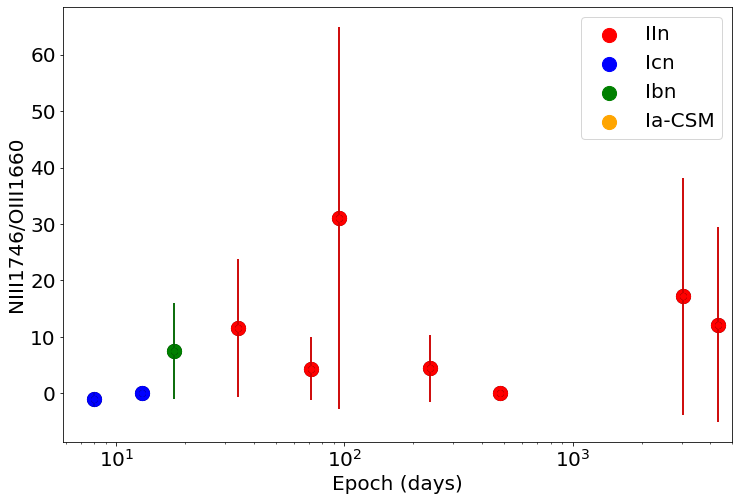

In [17]:
fig, ax = plt.subplots(figsize=(12,8))

#plt.errorbar(xax, yax, yerr=yerr_all, fmt="o", color="black")
#plt.scatter(xax, yax, marker='o',s=200, color="black")
plt.errorbar(phase, yax, yerr=yerr_all, fmt="o", color="black")
plt.scatter(phase, yax, marker='o',s=200, color="black")

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
#plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
#plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")
plt.errorbar(phase[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(phase[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

#ax.set_xlabel("NIV1483",size=20)
ax.set_xlabel("Epoch (days)")
ax.set_ylabel("NIII1746/OIII1660",size=20)
plt.xscale('log')

#xaxlabel=xax+0.1e-14
xaxlabel=phase
yaxlabel=yax


for i in range(len(obj)):
    label = sntype[i]+' '+str(phase[i])
    print,label
    #if xaxlabel[i] < 500:
    #    plt.text(xaxlabel[i],yax[i],label,fontsize=12)

plt.legend()
#plt.ylim([3,10])
plt.xlim([0,5000])
plt.rcParams.update({'font.size': 20})
plt.savefig('NIII1746dOIII1660.jpg', dpi=100)
plt.show()

In [40]:
#NIII1746/OIII1660
yax = np.array(NIII1746)/np.array(OIII1660)
xax = np.array(NIII1746)
xerr = np.array(d_NIII1746)
yerr_all = abs(yax)*[abs(np.array(d_NIII1746)/np.array(NIII1746)) + abs(np.array(d_OIII1660)/np.array(OIII1660))]
yerr_all = yerr_all.flatten()

/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2909233046.py:2: RuntimeWarning: divide by zero encountered in true_divide
  yax = np.array(NIII1746)/np.array(OIII1660)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/2909233046.py:5: RuntimeWarning: invalid value encountered in true_divide
  yerr_all = abs(yax)*[abs(np.array(d_NIII1746)/np.array(NIII1746)) + abs(np.array(d_OIII1660)/np.array(OIII1660))]


/Users/ofox/miniconda3/envs/ers1288/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_41451/671054898.py:32: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([-0.1e-13,0.2e-13])


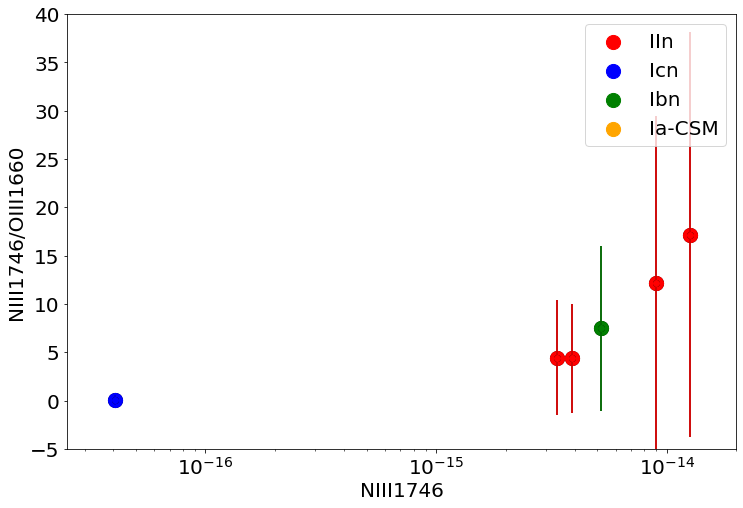

In [42]:
fig, ax = plt.subplots(figsize=(12,8))

plt.errorbar(xax, yax, yerr=yerr_all, fmt="o",color="black")
plt.scatter(xax, yax, marker='o',s=200,color="black")

tmp=np.where(np.array(sntype) == 'IIn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='red')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='red',label="IIn")

tmp=np.where(np.array(sntype) == 'Icn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='blue')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='blue',label="Icn")

tmp=np.where(np.array(sntype) == 'Ibn')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='green')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='green',label="Ibn")

tmp=np.where(np.array(sntype) == 'Ia-CSM')
tmp=tmp[0].flatten()
plt.errorbar(xax[tmp], yax[tmp], yerr=yerr_all[tmp], fmt="o", color='orange')
plt.scatter(xax[tmp], yax[tmp], marker='o',s=200, color='orange',label="Ia-CSM")

ax.set_xlabel("NIII1746")
ax.set_ylabel("NIII1746/OIII1660",size=20)
plt.xscale('log')

plt.legend()
plt.ylim([-5,40])
plt.xlim([-0.1e-13,0.2e-13])
plt.rcParams.update({'font.size': 20})
plt.savefig('NIII1746dOIII1660_colormag.jpg')
plt.show()